<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/9%EC%A3%BC%EC%B0%A8/TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ==========================================
# 1. 데이터 로드
# ==========================================
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSLA.csv')

# 필요한 열만 선택
df = df[['Open', 'High', 'Low', 'Close']]

# NaN 제거
df.dropna(inplace=True)

In [5]:
# ==========================================
# 2. 정규화
# ==========================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[['Open', 'High', 'Low']])
y_scaled = scaler_y.fit_transform(df[['Close']])

In [7]:
# ==========================================
# 3. 시퀀스 생성 (window=6)
# ==========================================
window = 6
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])      # 6일치 입력
    y.append(y_scaled[i+window])        # 다음날 종가 예측
X, y = np.array(X), np.array(y)

In [8]:
# ==========================================
# 4. Train/Test 분할 (8:2)
# ==========================================
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
# ==========================================
# 5. RNN 모델
# ==========================================
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='tanh', input_shape=(window, 3)),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# ==========================================
# 6. LSTM 모델
# ==========================================
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(window, 3)),
    tf.keras.layers.LSTM(32, activation='tanh'),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

In [11]:
# ==========================================
# 7. 모델 학습
# ==========================================
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0952e-04 - val_loss: 0.0115
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5134e-06 - val_loss: 0.0077
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3522e-06 - val_loss: 0.0073
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1454e-06 - val_loss: 0.0037
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0912e-06 - val_loss: 0.0026
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9411e-06 - val_loss: 0.0025
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9734e-06 - val_loss: 0.0025
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1897e-06 - val_loss: 0.0025
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3191e-06 - val_loss: 0.0016
Epoch 10/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2766e-06 - val_loss: 8.1017e-04
Epoch 11/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0179e-06 - val_loss: 6.9123e-04


In [12]:
# ==========================================
# 8. 테스트 예측 (앙상블 평균)
# ==========================================
pred_rnn = model_rnn.predict(X_test)
pred_lstm = model_lstm.predict(X_test)
final_pred = (pred_rnn + pred_lstm) / 2

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


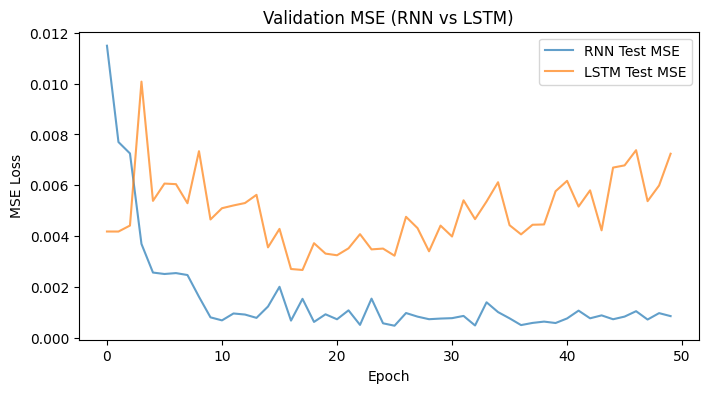

In [13]:
# ==========================================
# 9. MSE 시각화
# ==========================================
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['val_loss'], label='RNN Test MSE', alpha=0.7)
plt.plot(history_lstm.history['val_loss'], label='LSTM Test MSE', alpha=0.7)
plt.title('Validation MSE (RNN vs LSTM)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

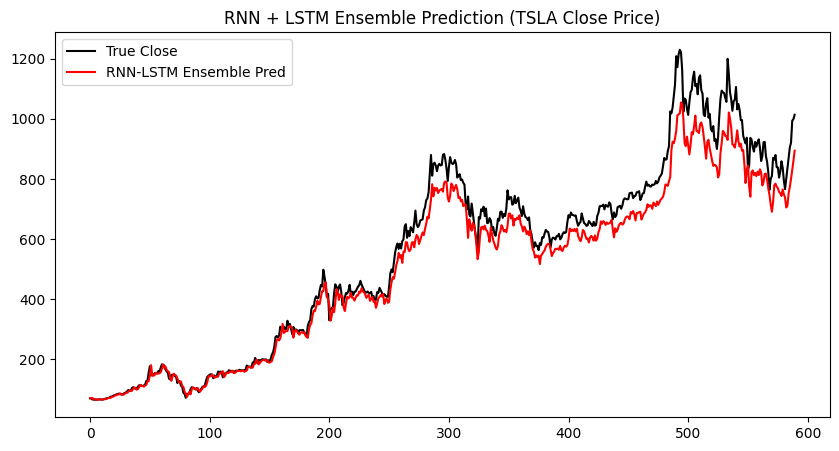

In [14]:
# ==========================================
# 10. 실제값 vs 예측값 시각화
# ==========================================
true_vals = scaler_y.inverse_transform(y_test)
pred_avg = scaler_y.inverse_transform(final_pred)

plt.figure(figsize=(10,5))
plt.plot(true_vals, label='True Close', color='black')
plt.plot(pred_avg, label='RNN-LSTM Ensemble Pred', color='red')
plt.title('RNN + LSTM Ensemble Prediction (TSLA Close Price)')
plt.legend()
plt.show()